# Final Model

This notebook focuses on the baseline and final models used for this classification project.
<br>
<br>
For this project, I have focused on increasing the model's accuracy score given that I believe a false positive and false negativ are equally "bad". In this specific data set, a false positive means that the model misclassified a book as a bestseller and a false negative means that the model misclassified a book as NOT a bestseller.


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import itertools

In [2]:
df = pd.read_csv('final_dataframe.csv',index_col=0)

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
# select the columns to be features in the model
feats = ['series','rating','publish_month','publish_company','genre','top_authors']

# get dummies for the categorical data
X = pd.get_dummies(df[feats], drop_first=True)

Y = df['NYT_bestseller']

In [5]:
X.columns

Index(['series', 'rating', 'top_authors', 'publish_month_August',
       'publish_month_December', 'publish_month_February',
       'publish_month_January', 'publish_month_July', 'publish_month_June',
       'publish_month_March',
       ...
       'genre_short-stories', 'genre_spirituality', 'genre_sports-and-games',
       'genre_suspense', 'genre_thriller', 'genre_travel', 'genre_westerns',
       'genre_womens-fiction', 'genre_writing', 'genre_young-adult'],
      dtype='object', length=529)

In [6]:
# for publisher, genre, and month of publishing dummy variables, i only want the "important ones" (i.e. the ones
# that will actually impact the models) which i have deemed to be anything where the count was over 10 

X.drop([col for col, val in X.sum().iteritems() if val < 15], axis=1, inplace=True)

In [7]:
# normalize the features

for col in X.columns:
    X[col] = (X[col]-min(X[col]))/ (max(X[col]) - min(X[col])) 

#We subtract the minimum and divide by the range forcing a scale of 0 to 1 for each feature

X.head()

,series,rating,top_authors,publish_month_August,publish_month_December,publish_month_February,publish_month_January,publish_month_July,publish_month_June,publish_month_March,publish_month_May,publish_month_November,publish_month_October,publish_month_September,publish_company_Hachette,publish_company_Harper Collins,publish_company_Houghton Mifflin Harcourt,publish_company_Macmillan,publish_company_Penguin Random House,publish_company_Simon & Schuster,genre_biography,genre_childrens,genre_fantasy,genre_fiction,genre_historical,genre_history,genre_horror,genre_mystery,genre_non-fiction,genre_poetry,genre_politics,genre_romance,genre_science-fiction,genre_sequential-art,genre_short-stories,genre_thriller,genre_young-adult
0,0.0,0.624434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.597285,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.588235,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.619910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.583710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

## Helper functions

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion')

In [14]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [15]:
def plot_AUC_ROC(y_score,fpr,tpr):
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Baseline: Dummy Classifier

The Dummy Classifier employs a strategy of selecting the most frequent class for each observation. Given the data set has more non-bestsellers than bestsellers, the model consistently predicts non-bestsellers with an accuracy score of ~68%. 

In [9]:
dum_clf = DummyClassifier(strategy='most_frequent')
dum_model = dum_clf.fit(X_train,y_train)
y_hat_train = dum_clf.predict(X_train)
y_hat_test = dum_model.predict(X_test)

In [10]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [11]:
print_metrics(y_hat_test,y_test)

Precision Score: 0.0
Recall Score: 0.0
Accuracy Score: 0.6727272727272727
F1 Score: 0.0


/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Confusion matrix, without normalization
[[222   0]
 [108   0]]


<Figure size 432x288 with 0 Axes>

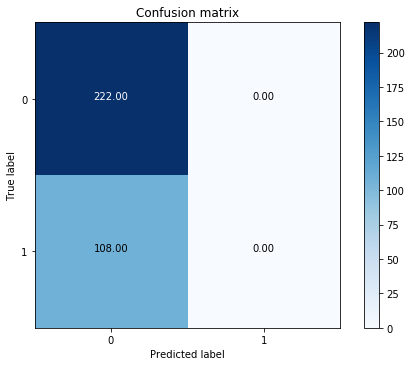

In [16]:
cnf_matrix = confusion_matrix(y_test, y_hat_test)

plt.figure()
plt.figure(figsize=(7,5))

plot_confusion_matrix(cnf_matrix, classes=[0,1],normalize=False,
                      title='Confusion matrix')
plt.savefig('Confusion_Matrix_baseline')

In [ ]:
# this model has no observations classified as positives, which is why the right side of the matrix is empty

# there were 222 correctly classified negatives and 108 incorrectly classified negatives

# Final: Logistic Regression

The model which was most accurate in predicting bestselling books is Logistic Regression. The model, using the default parameters from sklearn, has a 74% accuracy score (~6-7% higher than the baseline).

In [17]:
logreg = LogisticRegression(solver='liblinear')
model_log = logreg.fit(X_train, y_train)
model_log

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [18]:
# y_hat are predicted values
y_hat_test_log = logreg.predict(X_test)
y_hat_train_log = logreg.predict(X_train)

In [19]:
# metrics
print_metrics(y_hat_train_log, y_train)
print('----------')
print_metrics(y_hat_test_log,y_test)

Precision Score: 0.36794582392776526
Recall Score: 0.6468253968253969
Accuracy Score: 0.7196048632218845
F1 Score: 0.4690647482014389
----------
Precision Score: 0.37962962962962965
Recall Score: 0.6721311475409836
Accuracy Score: 0.7363636363636363
F1 Score: 0.48520710059171596


[[202  20]
 [ 67  41]]
Confusion matrix, without normalization
[[202  20]
 [ 67  41]]


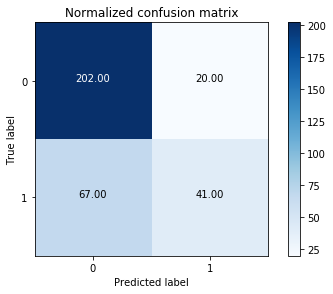

In [20]:
# confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat_test_log)
print(cnf_matrix)
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=False,classes=[0,1],
                      title='Normalized confusion matrix')
plt.savefig('Confusion_Matrix_Log')


In [ ]:
# given class imbalance, the model is better at predicting negatives than it is at predicting positives as expected
# True positives: 41
# FP: 67
# TN: 202
# FN: 20

In [21]:
# find the coefficients for each column
# those with the highest absolute values have the strongest impact on predicting bestsellers

coef_dict = {}
for coef, feat in zip(model_log.coef_[0,:],X.columns):
    coef_dict[feat] = coef
sorted(coef_dict.items(), key=lambda x: x[1])

[('genre_science-fiction', -1.7851529866647473),
 ('genre_horror', -1.6899299448531002),
 ('genre_fantasy', -1.560018488945462),
 ('genre_short-stories', -1.501014877088237),
 ('genre_young-adult', -1.2392667458225803),
 ('genre_romance', -1.2335241550110074),
 ('genre_historical', -1.2134203119474598),
 ('genre_fiction', -1.1571221799535654),
 ('genre_mystery', -0.7180423115898127),
 ('publish_month_May', -0.6558644834266053),
 ('publish_month_July', -0.5384410579420981),
 ('publish_month_January', -0.43812205618665573),
 ('publish_month_March', -0.3896595773527477),
 ('genre_thriller', -0.3751005132598331),
 ('publish_month_February', -0.36155821220085005),
 ('genre_sequential-art', -0.30464203553027175),
 ('publish_company_Simon & Schuster', -0.2314497324786993),
 ('genre_poetry', -0.21235754328245443),
 ('publish_month_June', -0.10704957120915491),
 ('publish_company_Macmillan', -0.08073274389211683),
 ('genre_history', -0.07794014153298508),
 ('publish_month_October', -0.043508701

In [24]:
y_test_score = model_log.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_test_score)

y_train_score = model_log.decision_function(X_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

AUC: 0.7792584250917584


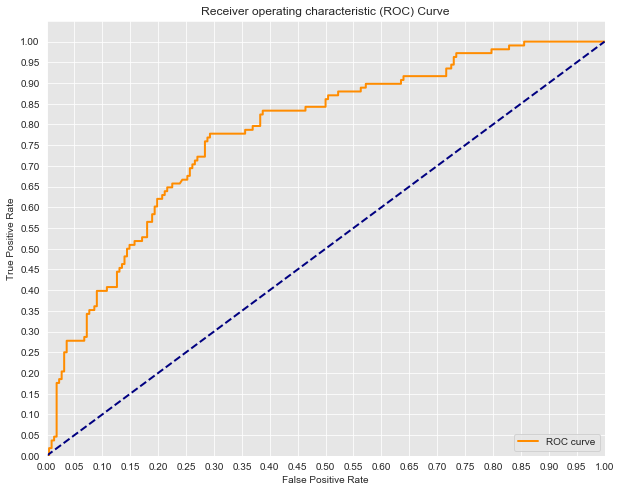

In [25]:
# plot the ROC - this shows the tradeoff between classifying true and false positives
plot_AUC_ROC(y_test_score,fpr,tpr)

## Grid Search

Based on the output from grid search, which tests out the optimal parameters from the options you provide it with, the default parameters for sklearn's Logistic Regression are the parameters for which the model returns  the highest accuracy score.

In [26]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

clf_2 = GridSearchCV(LogisticRegression(solver='liblinear'), hyperparameters, cv=5, verbose=0,scoring='accuracy')

In [27]:
best_model = clf_2.fit(X_train, y_train)

In [28]:
best_model.best_estimator_

LogisticRegression(C=7.742636826811269, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [29]:
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 7.742636826811269


In [30]:
logreg_2 = best_model.best_estimator_

In [31]:
logreg_2.fit(X_train, y_train)

LogisticRegression(C=7.742636826811269, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [32]:
y_hat2 = logreg_2.predict(X_test)

In [33]:
print_metrics(y_hat2,y_test)

Precision Score: 0.4074074074074074
Recall Score: 0.6027397260273972
Accuracy Score: 0.7181818181818181
F1 Score: 0.4861878453038674


In [ ]:
# this gives us a lower accuracy score than the default parameters